In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import ipywidgets
import jupyterlab_widgets
from tqdm.auto import tqdm
import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
print(os.listdir('/kaggle/input/brain-tumor'))

['2', '3', '1']


In [3]:
data_dir = '/kaggle/input/brain-tumor'

In [4]:
print(os.listdir('/kaggle/input/brain-tumor/2')[0:7])

['1231.png', '641.png', '1088.png', '173.png', '1958.png', '815.png', '491.png']


In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2

In [6]:
#Visualize a sample
sample=cv2.imread('/kaggle/input/brain-tumor/2/641.png')
sample.shape

(512, 512, 3)

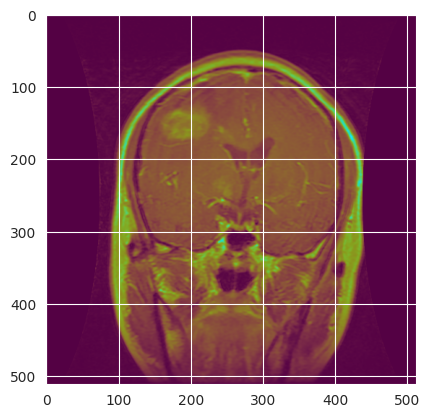

In [7]:
plt.imshow(sample)

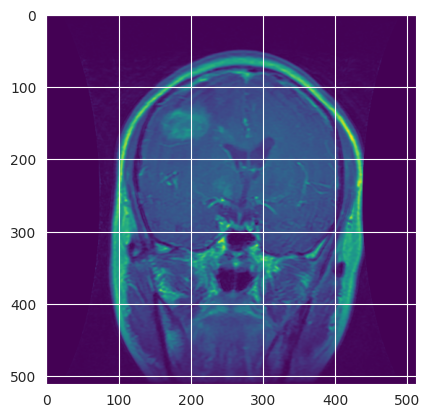

In [8]:
sample_1= cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)
plt.imshow(sample_1)

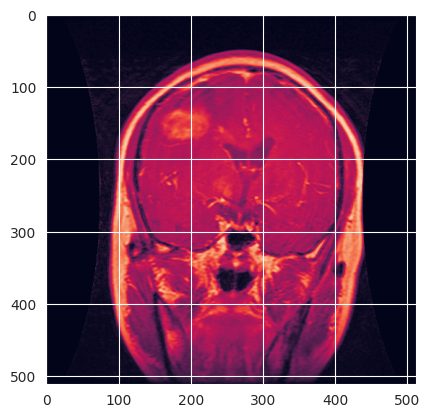

In [9]:
sample_2 = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
plt.imshow(sample_2)

In [10]:
sample_2.shape

(512, 512)

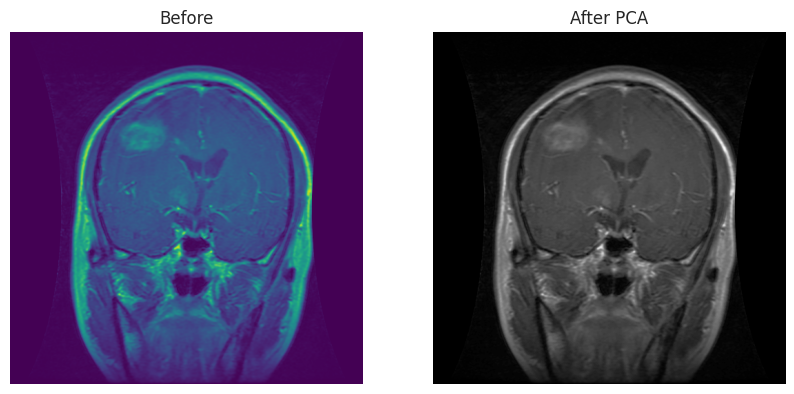

Original Image Size: 243.849 KB
Compressed Image Size: 84.938 KB


In [11]:
# Test PCA and KMeans on Datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
import numpy as np

image = cv2.imread('/kaggle/input/brain-tumor/2/641.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply PCA
pca = PCA()
transformed_image = pca.inverse_transform(pca.fit_transform(image_gray.reshape(-1, 1)))

# Reshape the transformed image back to the original shape
transformed_image_gray = transformed_image.reshape(image_gray.shape)
clf = KMeans(n_clusters=3, n_init='auto')
clf.fit(transformed_image)
pixels_seg0 = clf.cluster_centers_[clf.labels_]
pixels_seg = np.clip(pixels_seg0, 0, 255)
image_seg = pixels_seg.reshape(image_gray.shape)

fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(image_rgb)
axarr[0].set_title(f'Before')
axarr[1].imshow(transformed_image_gray, cmap = 'gray')
axarr[1].set_title(f'After PCA')
# Turn off the axis labels
for ax in axarr:
    ax.axis('off')

# Show the subplots
plt.show()

cv2.imwrite('original_image.png', image_rgb)
cv2.imwrite('transformed_image.png', transformed_image_gray)

def get_size(file_path, unit='bytes'):
    file_size = os.path.getsize(file_path)
    exponents_map = {'bytes': 0, 'kb': 1, 'mb': 2, 'gb': 3}
    if unit not in exponents_map:
        raise ValueError("Must select from \
        ['bytes', 'kb', 'mb', 'gb']")
    else:
        size = file_size / 1024 ** exponents_map[unit]
        return round(size, 3)

original_size = get_size('original_image.png', 'kb')
transformed_size = get_size('transformed_image.png', 'kb')

print(f"Original Image Size: {original_size} KB")
print(f"Compressed Image Size: {transformed_size} KB")

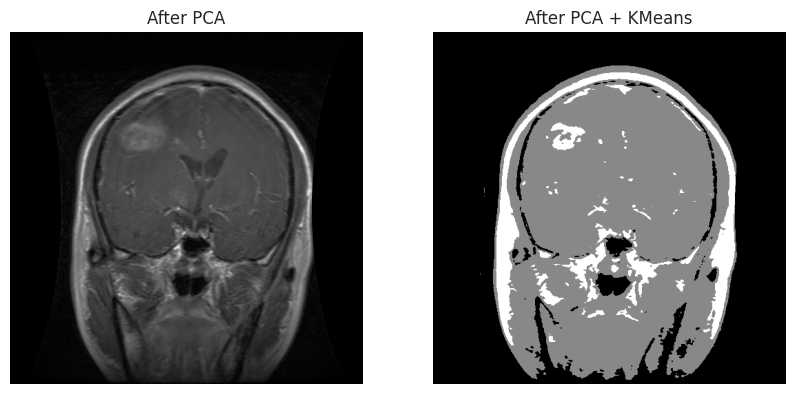

PCA Image Size: 84.938 KB
Segmented (K-Means) Image Size: 11.737 KB


In [12]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(transformed_image_gray, cmap = 'gray')
axarr[0].set_title(f'After PCA')
axarr[1].imshow(image_seg, cmap = 'gray')
axarr[1].set_title(f'After PCA + KMeans')
# Turn off the axis labels
for ax in axarr:
    ax.axis('off')

# Show the subplots
plt.show()

cv2.imwrite('original_image.png', transformed_image_gray)
cv2.imwrite('transformed_image.png', image_seg)

original_size = get_size('original_image.png', 'kb')
transformed_size = get_size('transformed_image.png', 'kb')

print(f"PCA Image Size: {original_size} KB")
print(f"Segmented (K-Means) Image Size: {transformed_size} KB")

In [13]:
# Generate data paths with labels
filepaths_2=[]
labels_2=[]
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            filepaths_2.append(fpath)
            if fold == '1':
                labels.append('meningioma')
                labels_2.append('meningioma')
            elif fold == '2':
                labels.append('glioma')
                labels_2.append('glioma')
            elif fold == '3':
                labels.append('pituitary tumor')
                labels_2.append('pituitary tumor')

    return filepaths, labels

# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [14]:
print(define_paths(data_dir)[0][7]),print(define_paths(data_dir)[1][7])

/kaggle/input/brain-tumor/2/1924.png
glioma


(None, None)

In [15]:
filepaths_2[7],labels_2[7]

('/kaggle/input/brain-tumor/2/1924.png', 'glioma')

In [16]:
len(filepaths_2),len(labels_2)

(6128, 6128)

In [17]:
#To create a dataframe
datos=np.array([filepaths_2,labels_2])

df=pd.DataFrame(data=[datos[0],datos[1]]).T
df.columns=['images','tipos']

In [18]:
df.head(7),df.tail(7)

(                                 images   tipos
 0  /kaggle/input/brain-tumor/2/1231.png  glioma
 1   /kaggle/input/brain-tumor/2/641.png  glioma
 2  /kaggle/input/brain-tumor/2/1088.png  glioma
 3   /kaggle/input/brain-tumor/2/173.png  glioma
 4  /kaggle/input/brain-tumor/2/1958.png  glioma
 5   /kaggle/input/brain-tumor/2/815.png  glioma
 6   /kaggle/input/brain-tumor/2/491.png  glioma,
                                     images       tipos
 6121  /kaggle/input/brain-tumor/1/2964.png  meningioma
 6122  /kaggle/input/brain-tumor/1/2652.png  meningioma
 6123  /kaggle/input/brain-tumor/1/3029.png  meningioma
 6124  /kaggle/input/brain-tumor/1/2383.png  meningioma
 6125  /kaggle/input/brain-tumor/1/2627.png  meningioma
 6126  /kaggle/input/brain-tumor/1/2392.png  meningioma
 6127  /kaggle/input/brain-tumor/1/2995.png  meningioma)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import ipywidgets
import jupyterlab_widgets
from tqdm.auto import tqdm
# Ignore Warnings
import warnings
import copy
import time
warnings.filterwarnings("ignore")

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.,), (1.,))  # Normalize image tensors
])

# Load the dataset
dataset = ImageFolder("/kaggle/input/brain-tumor", transform=transform)
display(dataset)

Dataset ImageFolder
    Number of datapoints: 3064
    Root location: /kaggle/input/brain-tumor
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.0,), std=(1.0,))
           )

In [22]:
# Load the dataset
dataset = ImageFolder("/kaggle/input/brain-tumor", transform=transform)
display(dataset)

Dataset ImageFolder
    Number of datapoints: 3064
    Root location: /kaggle/input/brain-tumor
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.0,), std=(1.0,))
           )

In [23]:
print(len(dataset))
class_names=dataset.classes
print(class_names)
print(len(class_names))

3064
['1', '2', '3']
3


In [24]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
num_epochs = 27



In [25]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)   

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(device)
                        targets = targets.to(device)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(device)
                        targets = targets.to(device)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array


def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [26]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3)  # 3 classes: glioma, meningioma, pituitary tumor
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [27]:
model_Simple_CNN=Simple_CNN().to(device)

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
	| New lowest val loss for model_Simple_CNN: 0.02587217578685692
Epoch: 2 | Learning rate: [0.00024544068644530265]
	| New lowest val loss for model_Simple_CNN: 0.02271824958468339
Epoch: 3 | Learning rate: [0.00014208203932499367]
	| New lowest val loss for model_Simple_CNN: 0.019633211377783275
Epoch: 4 | Learning rate: [5.4711762656368294e-05]
	| New lowest val loss for model_Simple_CNN: 0.018127276107887655
Epoch: 5 | Learning rate: [7.917960675006314e-06]
	| New lowest val loss for model_Simple_CNN: 0.017885800092488673
Epoch: 6 | Learning rate: [0.0]
Epoch: 7 | Learning rate: [5.729490168751576e-05]
	| New lowest val loss for model_Simple_CNN: 0.017729633006147227
Epoch: 8 | Learning rate: [0.00037500000000000033]
Epoch: 9 | Learning rate: [0.00037197560814373283]
	| New lowest val loss for model_Simple_CNN: 0.016826834025235198
Epoch: 10 | Learning rate: [0.0003750000000000003]
	| New lowest val loss for model_Simple_CNN: 0.01672073877849548
Ep

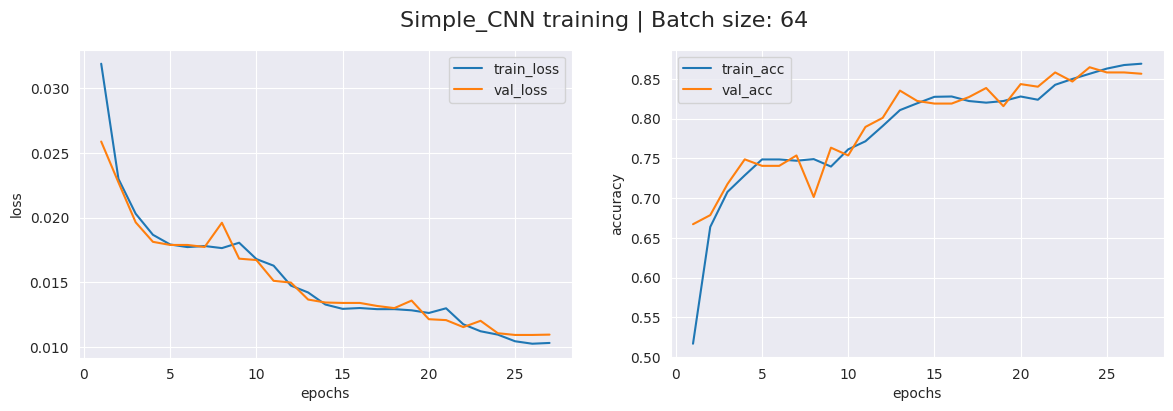


Training results:
	Min val loss 0.0109 was achieved during epoch #25
	Val accuracy during min val loss is 0.8581


In [28]:
Simple_CNN_training_results = training(model=model_Simple_CNN,
                                        model_name='model_Simple_CNN',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_loader,
                                        val_dataloader=val_loader)

model_Simple_CNN, train_loss_array, train_acc_array, val_loss_array, val_acc_array = Simple_CNN_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="Simple_CNN",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

                 precision    recall  f1-score   support

         glioma     0.7222    0.6594    0.6894       138
     meningioma     0.8737    0.8799    0.8768       283
pituitary tumor     0.9208    0.9688    0.9442       192

       accuracy                         0.8581       613
      macro avg     0.8389    0.8360    0.8368       613
   weighted avg     0.8543    0.8581    0.8557       613



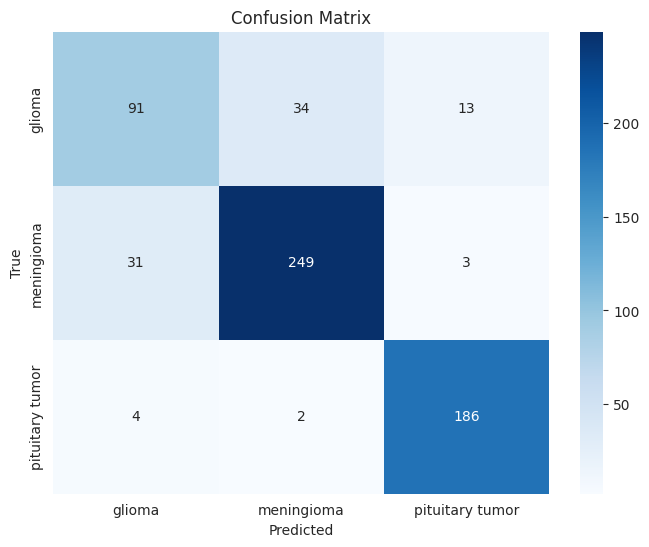

In [30]:
# Evaluation loop
model_Simple_CNN.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_Simple_CNN(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
# Define class labels
class_labels = ['glioma', 'meningioma', 'pituitary tumor']
print(classification_report(true_labels,predictions,target_names=class_labels,digits=4))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [31]:
#We are going to train a pretained model

!pip install efficientnet_pytorch
from torchvision import models

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a4552a91c35da4741b32ec2da374cf75f60b8802bdf0c88750957abfe0f5d9db
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [32]:
from efficientnet_pytorch import EfficientNet
model_Efficientnet = EfficientNet.from_pretrained('efficientnet-b3')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 186MB/s]


Loaded pretrained weights for efficientnet-b3


In [33]:
for param in model_Efficientnet.parameters():
  param.requires_grad = False


In [34]:
from torch import Tensor, nn
from torch.nn.functional import interpolate

In [35]:
in_features=model_Efficientnet._fc.in_features

In [36]:
in_features

1536

In [37]:
model_Efficientnet._fc = nn.Sequential(
                         nn.Linear(in_features, 625),  # 1st Linear Layer of taking n_inputs, and outputing 256 sized tensor
                         nn.ReLU(),                # a ReLu activation function is applied to the output of the 1st Linear Layer
                         nn.Dropout(0.3),  
                         nn.Linear(625,256),
                         nn.ReLU(),
                         nn.Dropout(0.4),# a DropOut Layer, which randomly assigns 40% of the output as zero to prevent OverFitting.
                         nn.Linear(256,3),# 2nd Linear Layer of taking 256 input and outputs n_classes ( in this case 3)
                         nn.LogSoftmax(dim = 1)    # a LogSoftMax function
)

In [38]:
model_Efficientnet

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [39]:
total_params, total_trainable_params = 0, 0

for p in model_Efficientnet.parameters():
  total_params += p.numel()
  if p.requires_grad :
    total_trainable_params += p.numel()

print(str(total_params) + ' total number of parameter out of which ' + str(total_trainable_params) + ' are trainable parameters.')

11817884 total number of parameter out of which 1121652 are trainable parameters.


In [40]:
!pip install torch-summary
from torchsummary import  summary
model_Efficientnet.to(device) # move the model to GPU
summary(model_Efficientnet,input_size=(3,64,64))

  Obtaining dependency information for torch-summary from https://files.pythonhosted.org/packages/ca/db/93d18c84f73b214acfa4d18051d6f4263eee3e044c408928e8abe941a22c/torch_summary-1.4.5-py3-none-any.whl.metadata
Layer (type:depth-idx)                             Param #
├─Conv2dStaticSamePadding: 1-1                     --
|    └─ZeroPad2d: 2-1                              --
├─BatchNorm2d: 1-2                                 (80)
├─ModuleList: 1-3                                  --
|    └─MBConvBlock: 2-2                            --
|    |    └─Conv2dStaticSamePadding: 3-1           (360)
|    |    └─BatchNorm2d: 3-2                       (80)
|    |    └─Conv2dStaticSamePadding: 3-3           (410)
|    |    └─Conv2dStaticSamePadding: 3-4           (440)
|    |    └─Conv2dStaticSamePadding: 3-5           (960)
|    |    └─BatchNorm2d: 3-6                       (48)
|    |    └─MemoryEfficientSwish: 3-7              --
|    └─MBConvBlock: 2-3                            --
|    |    

Layer (type:depth-idx)                             Param #
├─Conv2dStaticSamePadding: 1-1                     --
|    └─ZeroPad2d: 2-1                              --
├─BatchNorm2d: 1-2                                 (80)
├─ModuleList: 1-3                                  --
|    └─MBConvBlock: 2-2                            --
|    |    └─Conv2dStaticSamePadding: 3-1           (360)
|    |    └─BatchNorm2d: 3-2                       (80)
|    |    └─Conv2dStaticSamePadding: 3-3           (410)
|    |    └─Conv2dStaticSamePadding: 3-4           (440)
|    |    └─Conv2dStaticSamePadding: 3-5           (960)
|    |    └─BatchNorm2d: 3-6                       (48)
|    |    └─MemoryEfficientSwish: 3-7              --
|    └─MBConvBlock: 2-3                            --
|    |    └─Conv2dStaticSamePadding: 3-8           (216)
|    |    └─BatchNorm2d: 3-9                       (48)
|    |    └─Conv2dStaticSamePadding: 3-10          (150)
|    |    └─Conv2dStaticSamePadding: 3-11          

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
	| New lowest val loss for Efficientnet: 0.037729701735261606
Epoch: 2 | Learning rate: [0.00024544068644530265]
Epoch: 3 | Learning rate: [0.00014208203932499367]
	| New lowest val loss for Efficientnet: 0.035542559370909
Epoch: 4 | Learning rate: [5.4711762656368294e-05]
	| New lowest val loss for Efficientnet: 0.03382828603171991
Epoch: 5 | Learning rate: [7.917960675006314e-06]
	| New lowest val loss for Efficientnet: 0.02889776784094084
Epoch: 6 | Learning rate: [0.0]
	| New lowest val loss for Efficientnet: 0.02473913514789127
Epoch: 7 | Learning rate: [5.729490168751576e-05]
	| New lowest val loss for Efficientnet: 0.02102336584063183
Epoch: 8 | Learning rate: [0.00037500000000000033]
	| New lowest val loss for Efficientnet: 0.020083688746463223
Epoch: 9 | Learning rate: [0.00037197560814373283]
	| New lowest val loss for Efficientnet: 0.01881566420075944
Epoch: 10 | Learning rate: [0.0003750000000000003]
	| New lowest val loss for Efficientnet

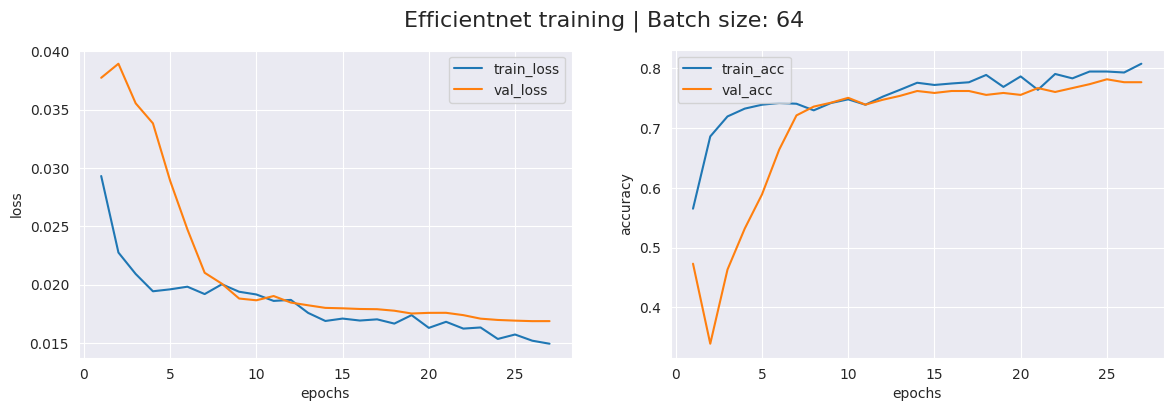


Training results:
	Min val loss 0.0169 was achieved during epoch #26
	Val accuracy during min val loss is 0.7765


In [41]:
Efficientnet_training_results = training(model=model_Efficientnet,
                                     model_name='Efficientnet',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_loader,
                                     val_dataloader=val_loader)

model_Efficientnet, train_loss_array, train_acc_array, val_loss_array, val_acc_array = Efficientnet_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="Efficientnet",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

                 precision    recall  f1-score   support

         glioma     0.6053    0.5000    0.5476       138
     meningioma     0.7973    0.8198    0.8084       283
pituitary tumor     0.8413    0.9115    0.8750       192

       accuracy                         0.7765       613
      macro avg     0.7480    0.7437    0.7437       613
   weighted avg     0.7678    0.7765    0.7705       613



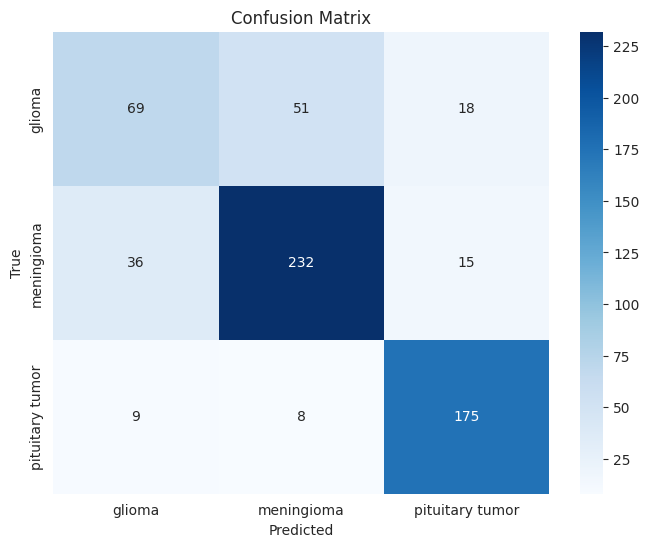

In [42]:
# Evaluation loop
model_Efficientnet.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_Efficientnet(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels
class_labels = ['glioma', 'meningioma', 'pituitary tumor']
print(classification_report(true_labels,predictions,target_names=class_labels,digits=4))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [43]:
#We are going to train an ensemble model

In [44]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(3 * 2, 3)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_Simple_CNN, model_Efficientnet)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(device)

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
	| New lowest val loss for Ensemble: 0.022131552801241103
Epoch: 2 | Learning rate: [0.00024544068644530265]
	| New lowest val loss for Ensemble: 0.018482330281038267
Epoch: 3 | Learning rate: [0.00014208203932499367]
	| New lowest val loss for Ensemble: 0.016794239424570156
Epoch: 4 | Learning rate: [5.4711762656368294e-05]
	| New lowest val loss for Ensemble: 0.016091069768731394
Epoch: 5 | Learning rate: [7.917960675006314e-06]
	| New lowest val loss for Ensemble: 0.01591390760259955
Epoch: 6 | Learning rate: [0.0]
Epoch: 7 | Learning rate: [5.729490168751576e-05]
	| New lowest val loss for Ensemble: 0.015742280841068188
Epoch: 8 | Learning rate: [0.00037500000000000033]
	| New lowest val loss for Ensemble: 0.015164253616410795
Epoch: 9 | Learning rate: [0.00037197560814373283]
	| New lowest val loss for Ensemble: 0.01438913512579963
Epoch: 10 | Learning rate: [0.0003750000000000003]
	| New lowest val loss for Ensemble: 0.013646416426871769
Epoch: 

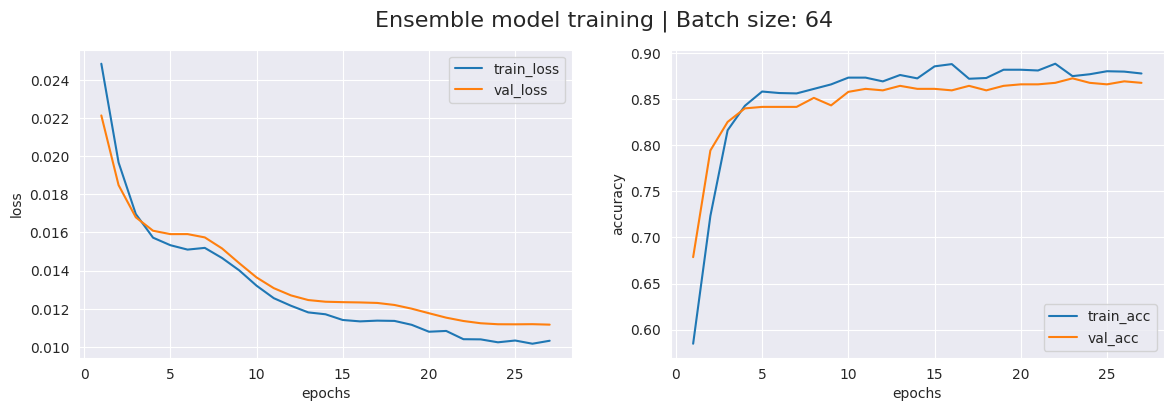


Training results:
	Min val loss 0.0112 was achieved during iteration #27
	Val accuracy during min val loss is 0.8679


In [45]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=27,
                                     train_dataloader=train_loader,
                                     val_dataloader=val_loader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=27,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

                 precision    recall  f1-score   support

         glioma     0.7857    0.6377    0.7040       138
     meningioma     0.8629    0.9117    0.8866       283
pituitary tumor     0.9208    0.9688    0.9442       192

       accuracy                         0.8679       613
      macro avg     0.8565    0.8394    0.8449       613
   weighted avg     0.8636    0.8679    0.8635       613



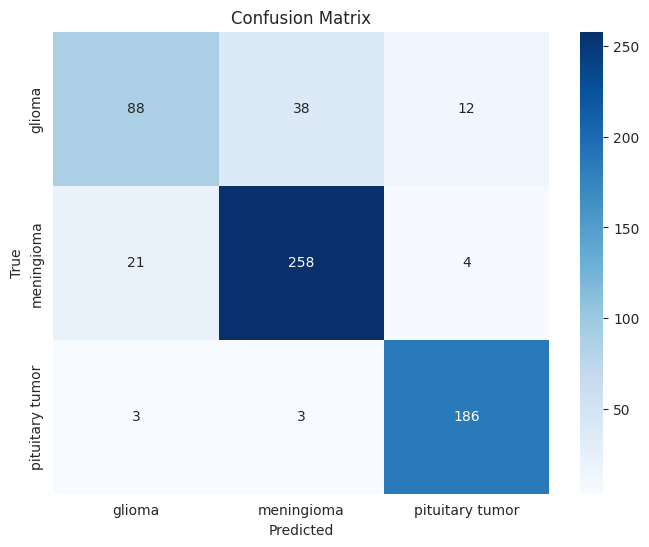

In [46]:
# Evaluation loop
ensemble_model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs =ensemble_model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels
class_labels = ['glioma', 'meningioma', 'pituitary tumor']
print(classification_report(true_labels,predictions,target_names=class_labels,digits=4))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()